In [70]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [71]:
import sim as vrep
import time
import cv2
import numpy as np

# Get images from visual sensor

In [72]:
vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    images = []
    orientations = []
    grays = []
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 12
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            # save each image to an array
            images.append(img)
            #returnCodeOrientation,eulerAngles = vrep.simxGetObjectOrientation(clientID, v1, -1, [0, 0, 0])
            #orientations.append(eulerAngles)
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(2.5)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!


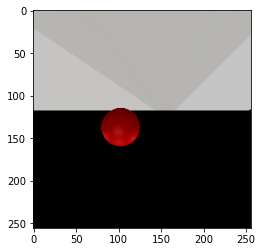

In [73]:
imshow(img)

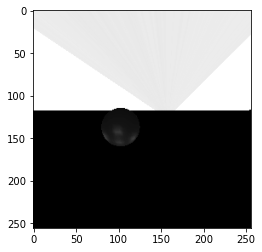

In [74]:
# Convert each image to gray scale
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imshow(gray, cmap='gray')
    grays.append(gray)

[[[243.5 134.5  43.5]
  [ 21.5 142.5  29.6]]]
[[[131.5 141.5  31.7]]]
[[[203.5 140.5  29.7]
  [ 25.5 141.5  33.3]
  [119.5 237.5 120.6]
  [204.5  57.5  52.9]]]
[[[ 98.5 140.5  28.8]
  [ 53.5 141.5  23.6]]]
[[[157.5 147.5  45.2]
  [  1.5 140.5  28.3]]]
[[[ 51.5 149.5  48.8]
  [242.5 139.5  28.4]]]
[[[133.5 136.5  23.8]
  [ 95.5 160.5  44. ]]]
[[[196.5 152.5  53.1]
  [ 31.5 138.5  27.4]]]
[[[ 88.5 152.5  53.3]
  [223.5 141.5  31.8]
  [ 94.5   8.5  87.4]]]
[[[121.5 138.5  30.2]]]
[[[ 21.5 141.5  32.4]
  [205.5 136.5  25.2]]]
[[[102.5 136.5  22.1]]]


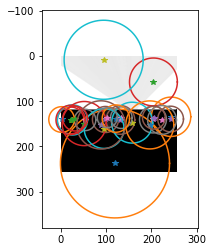

In [75]:
# array and for loop added because of checking multiple images
circleArr = []
for gray in grays:
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)

    imshow(gray, cmap='gray')
    print(circles)
    if circles is not None:
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2]  # In pixels
            circleArr.append(circle)

            # plot circle
            s = linspace(0,2*pi,100)
            cx = cos(s)*radius + center [0]
            cy = sin(s)*radius + center [1]
            # Plot center
            plot(center[0], center[1], '*')

            plot(cx,cy)


In [76]:
u0, v0 = 132, 132

#arrays added due to checking every sphere
radArr = []
kArr = []
xArr = []
zArr = []
for circle in circleArr:
    radius = circle[2]
    radArr.append(radius)
    center = (circle[0], circle[1])
    k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
    kArr.append(k)
    fov = 60  # degrees

    # number of pixels in x-axis
    npx = 264

    # maximum value in the x-axis (in meters)
    xmax = npx / (2.* k)

    # Distance to the center of the sphere (z-axis coordinate)
    zc = xmax / tan(pi/6)
    zc
    zArr.append(zc)

    # Location of the sphere in the x-axis coordinate
    xc = (center[0] - u0) / k
    xc
    xArr.append(xc)

    xc, zc

### Grid representation

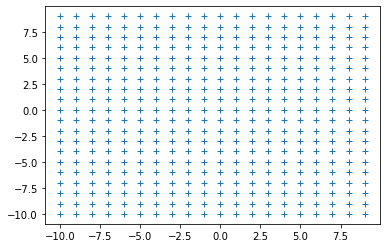

In [77]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

Draw each cell independently

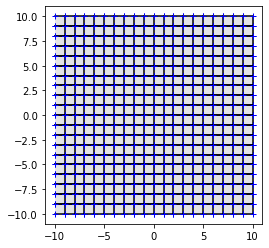

In [78]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

## Use the measurement

In [79]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# loop added because of arrays being added
for j in range(0, len(xArr)):
    xc = xArr[j]
    zc = zArr[j]
    radius = radArr[j]
    k = kArr[j]
    # For each cell, check if the circle is in it.
    for i in range(n*n):
        x, y = grid_x[i], grid_y[i]
        # Corners of the cell
        X, Y = points_cell(x, y, cell_w)

        # check based on the ecuclidean distance
        dist = sqrt((xc - X)**2 + (zc - Y)**2)

        # Check if At least one of the borders is within the sphere
        if((dist < radius/k).any()):
            print(dist)
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            print(li)
        else:
            po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle

            # Cells within the fov. Check if the four points are withing the FOV
            thetas = np.arctan2(Y,X) - pi/2
            if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li

            pass

# gmap

[1.31834717 0.94509877 0.09692376 0.9242412 ]
1.3862943611198908
[0.9242412  0.09692376 1.06093202 1.40371091]
1.3862943611198908
[0.94509877 1.4312177  1.07915088 0.09692376]
1.3862943611198908
[0.09692376 1.07915088 1.51021494 1.06093202]
1.3862943611198908
[1.4384946  0.81788068 0.28794691 1.21788806]
1.3862943611198908
[1.21788806 0.28794691 1.22347785 1.70212689]
1.3862943611198908
[0.81788068 1.12631741 0.82618128 0.28794691]
1.3862943611198908
[0.28794691 0.82618128 1.44795032 1.22347785]
-1.986716046617978
[1.72117648 1.40929337 0.40941466 1.06956115]
-5.359726454355847
[1.06956115 0.40941466 0.59087471 1.15129215]
-5.359726454355847
[1.15129215 0.59087471 1.59080027 1.8726949 ]
-5.359726454355847
[1.40929337 1.73486804 1.09145759 0.40941466]
-5.359726454355847
[0.40941466 1.09145759 1.17166217 0.59087471]
-5.359726454355847
[0.59087471 1.17166217 1.8852864  1.59080027]
-5.359726454355847
[1.11679267 0.79756808 0.29851258 0.83679196]
-8.732736862093716
[0.83679196 0.29851258 1.

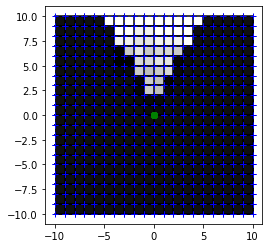

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()